In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import sklearn as sk
import numpy as np
import datetime
import psycopg2
import wordcloud

# EDA (Exploratory Data Analysis)

In [2]:
# Initilize the database connector
connector = psycopg2.connect(user = 'platzi',
                            password = 'platzi123',
                            host = 'localhost',
                            port = '5432',
                            database = 'platzi')

### Daily test

In [124]:
query_tests = '''
    SELECT
        Pivot.cantidad,
        Pivot.origin,
        Pivot.cal_date AS Date,
        CASE WHEN Pivot.Previous = 0 OR Pivot.Previous IS NULL THEN 
            0.0
        ELSE
            ((Pivot.cantidad - Pivot.Previous) / Pivot.Previous) * 100
        END
    FROM (
        SELECT
        T.cantidad,
        D.cal_date,
        O.origin,
        (LAG(T.cantidad) OVER (PARTITION BY O.origin ORDER BY D.cal_date)) AS Previous
        FROM tests T INNER JOIN origins O ON O.origin_id = T.origin_id INNER JOIN dates D ON D.date_id = T.date_id ORDER BY D.cal_date
    ) AS Pivot ORDER BY Pivot.cal_date; 
'''

df_test = pd.read_sql(query_tests, connector)
df_test.replace({'origin': {'PROCEDENCIA_DESCONOCIDA': float('NaN')}}, inplace = True)
df_test.dropna(subset = ['origin'], inplace = True)
df_test

cantidad     origin        date      case
0           0.0  RISARALDA  2020-03-05  0.000000
1           0.0     VAUPES  2020-03-05  0.000000
2           0.0  SANTANDER  2020-03-05  0.000000
3           0.0  MAGDALENA  2020-03-05  0.000000
4           0.0    BOLIVAR  2020-03-05  0.000000
...         ...        ...         ...       ...
10407  324806.0  ATLANTICO  2020-12-03  0.000000
10408   98858.0      HUILA  2020-12-03  0.346133
10409  104760.0      CESAR  2020-12-03  0.311198
10410   29204.0      CHOCO  2020-12-03  0.051389
10411  203744.0  SANTANDER  2020-12-03  0.836909

[9864 rows x 4 columns]

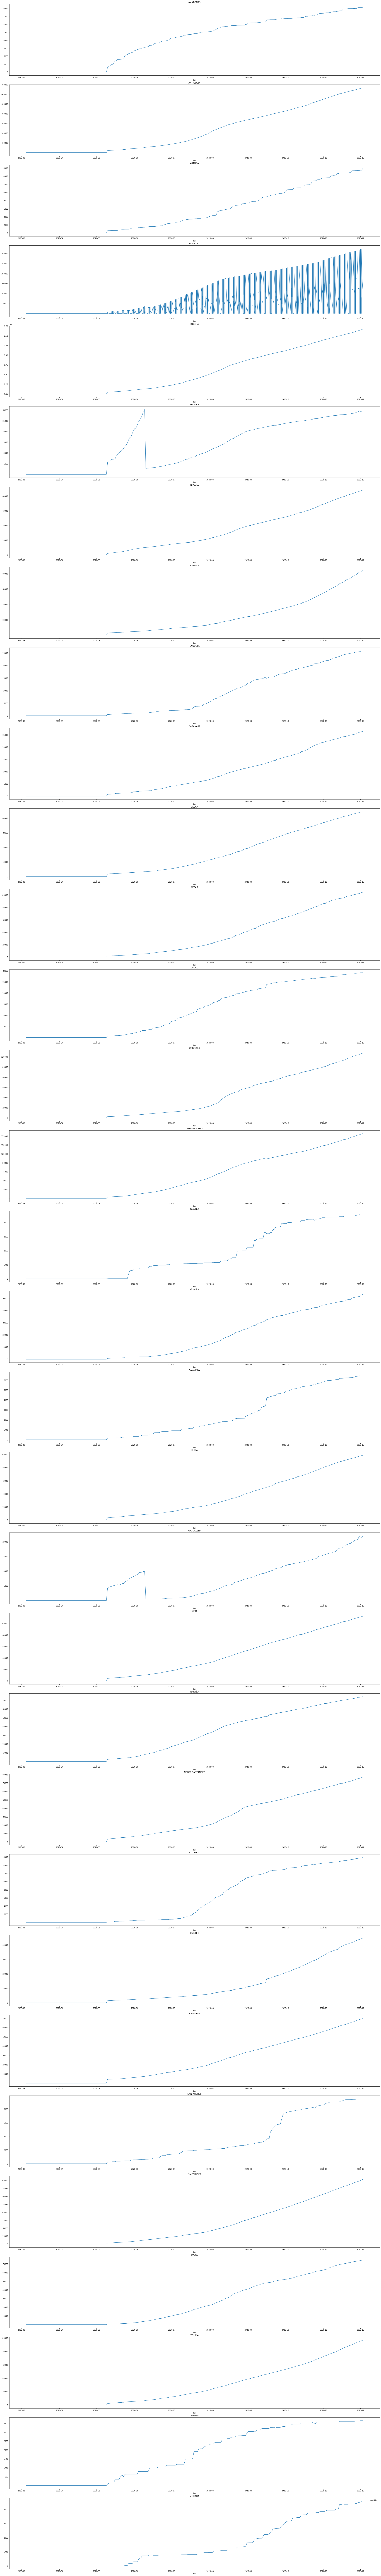

In [127]:
graph_df = df_test.copy()

graph_df.set_index('date', inplace = True)
grouped = graph_df.groupby('origin')['cantidad']

ncols = 1
nrows = int(np.ceil(grouped.ngroups / ncols))

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (30, 200))

fig.tight_layout(pad = 3.0)

for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
    grouped.get_group(key).plot(ax=ax, title = key) 

ax.legend()
plt.show()

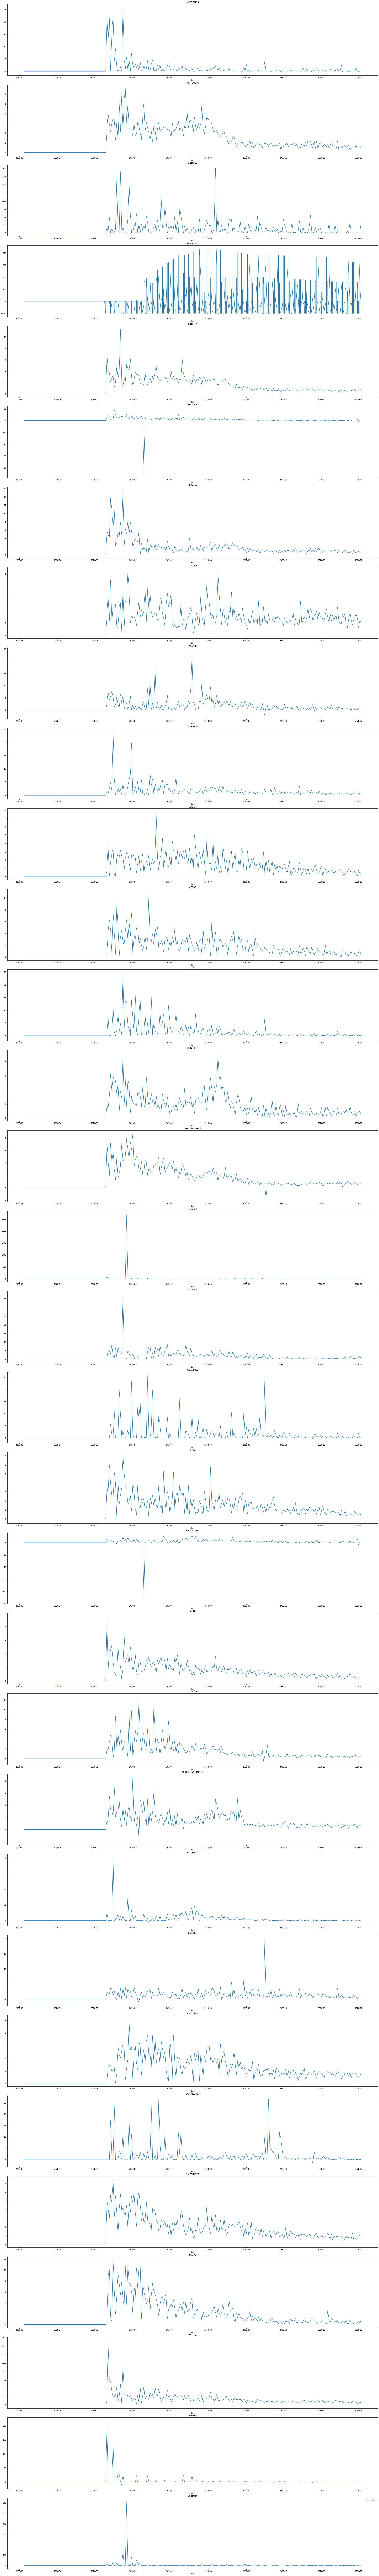

In [128]:
graph_df = df_test.copy()

graph_df.set_index('date', inplace = True)
grouped = graph_df.groupby('origin')['case']

ncols = 1
nrows = int(np.ceil(grouped.ngroups / ncols))

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (30, 200))

fig.tight_layout(pad = 3.0)

for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
    grouped.get_group(key).plot(ax=ax, title = key) 

ax.legend()
plt.show()

### Daily cases

## NLP

### News from 'El Tiempo'

In [261]:
query_news = '''
    SELECT
        Pivot.titulo AS Title,
        Pivot.resumen AS Resume,
        Pivot.cal_date AS Date,
        Pivot.month AS Month,
        Pivot.qtr AS Quarter
    FROM (
        SELECT
        N.titulo,
        N.resumen,
        D.cal_date,
        D.month,
        D.qtr
        FROM news N INNER JOIN dates D ON D.date_id = N.date_id ORDER BY D.cal_date
    ) AS Pivot ORDER BY Pivot.cal_date; 
'''

df_news = pd.read_sql(query_news, connector)
df_news['aggregate_text'] = df_news['title'] + df_news['resume']
df_news

title  \
0    el covid   una amenaza mundial que deja más de...   
1    coronavirus tiene nombre oficial  oms lo bauti...   
2    así sería la cuarentena en el país para los co...   
3    no se ha confirmado ningún caso de coronavirus...   
4    así será la evacuación y llegada de los colomb...   
..                                                 ...   
861  minsalud dice que por ahora no pedirá pruebas ...   
862  europa decide sobre primera vacuna covid  ante...   
863  colombia registra  muertes más y   nuevos caso...   
864  vacuna a toda costa  reflexiones tras días de ...   
865  alborada en antioquia deja los tres primeros l...   

                                                resume        date  month  \
0    según advirtió la organización mundial de la s...  2020-02-11  2       
1    nace del acrónimo en inglés a partir de la exp...  2020-02-11  2       
2    los  connacionales que serán evacuados de chin...  2020-02-18  2       
3    directivas del centro hospitalario indicaron q...  2020-02-19  2       
4    ministerio de salud sostiene que el viaje part...  2020-02-21  2       
..                                                 ...         ...    ...   
861  cartera envió preguntas al juez que con tutela...  2020-12-01  12      
862  agencia europea de medicamentos  ema  puso pla...  2020-12-01  12      
863  el ministerio de salud reportó también   recup...  2020-12-01  12      
864  análisis de alejandro gaviria  tatiana andia  ...  2020-12-01  12      
865  son dos menores y un joven de  años en medellí...  2020-12-01  12      

    quarter                                     aggregate_text  
0     1      el covid   una amenaza mundial que deja más de...  
1     1      coronavirus tiene nombre oficial  oms lo bauti...  
2     1      así sería la cuarentena en el país para los co...  
3     1      no se ha confirmado ningún caso de coronavirus...  
4     1      así será la evacuación y llegada de los colomb...  
..      ...                                                ...  
861   4      minsalud dice que por ahora no pedirá pruebas ...  
862   4      europa decide sobre primera vacuna covid  ante...  
863   4      colombia registra  muertes más y   nuevos caso...  
864   4      vacuna a toda costa  reflexiones tras días de ...  
865   4      alborada en antioquia deja los tres primeros l...  

[866 rows x 6 columns]

In [262]:
from sklearn.feature_extraction.text import CountVectorizer

with open('./files/stop_words.txt') as f:
    lines = f.read().splitlines()
    
cv = CountVectorizer(stop_words=lines)
data_cv = cv.fit_transform(df_news.aggregate_text)
originl_news_data = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
originl_news_data.index = df_news.month
data_dtm = originl_news_data.groupby(originl_news_data.index).sum()
data_dtm = data_dtm.transpose()
data_dtm

month       10     11     12     2      3      4      5      6      7      \
abandonado      0      0      0      0      0      1      0      0      0   
abecé           0      0      0      0      1      0      0      0      0   
abierta         1      0      0      0      1      0      0      0      0   
abrazo          0      0      0      0      0      0      0      0      1   
abre            0      0      0      0      0      0      0      0      0   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
último          2      0      0      0      1      1      3      5      3   
últimos         0      0      0      1      0      0      0      0      0   
única           0      0      0      0      1      0      0      0      0   
únicamente      0      0      0      0      0      0      0      0      1   
único           0      0      0      0      0      1      0      0      0   

month       8      9      
abandonado      0      0  
abecé           0      1  
abierta         0      0  
abrazo          0      0  
abre            0      1  
...           ...    ...  
último          2      2  
últimos         1      0  
única           0      0  
únicamente      0      0  
único           0      0  

[3546 rows x 11 columns]

In [263]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('spanish') + ['covid', 'https', 'http', 't', 'co', 'colombia', 'rt', 'caso', 'casos'])

data_clean = df_news[['month', 'aggregate_text']]
data_clean.set_index(['month'], inplace = True)
data_clean = data_clean.groupby(data_clean.index).transform(lambda x: ','.join(x))
data_clean.drop_duplicates(inplace = True)

def remove_stopword(sentence):
    word_tokens = word_tokenize(sentence)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]  
    filtered_sentence = []  

    for w in word_tokens:  
        if w not in stop_words:  
            filtered_sentence.append(w)
            
    return ' '.join(filtered_sentence)

data_clean.aggregate_text = data_clean.aggregate_text.apply(lambda x: remove_stopword(x))
data_clean

aggregate_text
month                                                   
2      amenaza mundial deja muertossegún advirtió org...
3      eleva alto riesgo coronavirus lleguecasos dos ...
4      tres muertes inquietanno presentaban comorbili...
5      confirman actor antonio bolívar murió coronavi...
6      van contagios recuperados además minsalud conf...
7      reportan nuevos muertos país van casosya recup...
8      rusia concluye pruebas clínicas primera vacuna...
9      puede confirmar reinfección sars cov colombiaa...
10     posibles nuevos picos ¿y ahora hacer expertos ...
11     director oms cuarentena tras contacto positivo...
12     minsalud dice ahora pedirá pruebas pcr entrar ...

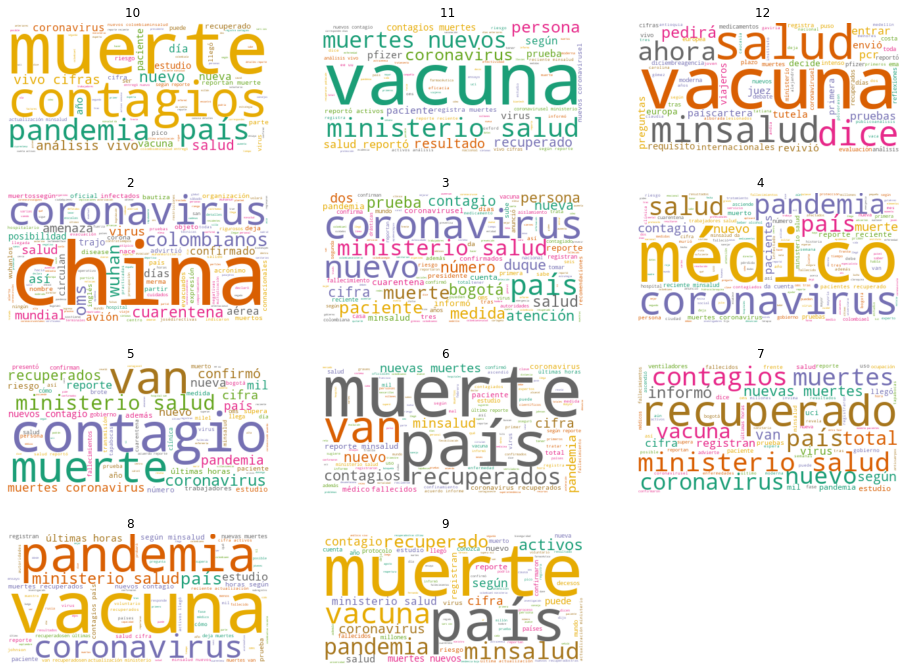

In [264]:
from wordcloud import WordCloud

wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)
 
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16,12]

for index, month in enumerate(data_dtm.columns):
    wc.generate(data_clean.aggregate_text[month])
    plt.subplot(4, 3, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(month)
plt.show()

In [277]:
c_vec = CountVectorizer(stop_words = stop_words, ngram_range=(2,3))
ngrams = c_vec.fit_transform(df_news['aggregate_text'])
count_values = ngrams.toarray().sum(axis = 0)
vocab = c_vec.vocabulary_

df_tweets_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})
df_tweets_ngram

frequency           bigram/trigram
0            111         ministerio salud
1             47           nuevas muertes
2             40         nuevos contagios
3             32            últimas horas
4             30           muertes nuevos
...          ...                      ...
15767          1    abecé recomendaciones
15768          1  abecé protocolo consumo
15769          1          abecé protocolo
15770          1   abandonado cali muerto
15771          1          abandonado cali

[15772 rows x 2 columns]

### Twitter Data

In [265]:
query_news = '''
    SELECT
        Pivot.texto AS Texto,
        Pivot.cal_date AS Date,
        Pivot.month AS Month,
        Pivot.day AS Day,
        Pivot.qtr AS Quarter
    FROM (
        SELECT
        T.texto,
        D.cal_date,
        D.month,
        D.day,
        D.qtr
        FROM tweets T INNER JOIN dates D ON D.date_id = T.date_id ORDER BY D.cal_date
    ) AS Pivot ORDER BY Pivot.cal_date; 
'''

df_tweets = pd.read_sql(query_news, connector)
df_tweets

texto        date  month  \
0    rt  coronavirusnewv  🇨🇴   colombia   se regist...  2020-11-29  11      
1    rt  wradiocolombia   actualidad   colombia alc...  2020-11-29  11      
2    rt  wradiocolombia   actualidad   bogotá ocupa...  2020-11-29  11      
3    a colombia cuando llegarán las vacunas contra ...  2020-11-29  11      
4    rt  odpdh   colombia 🇨🇴  comunicado conjunto a...  2020-11-29  11      
..                                                 ...         ...    ...   
843  si señores  colombia al mismo nivel que áfrica...  2020-12-02  12      
844   yorecomiendo conversatorio vacunas  status ac...  2020-12-02  12      
845  rt    titulares de miércoles  de diciembre en ...  2020-12-02  12      
846  rt  antoncaballeroh  el   también ha traído al...  2020-12-02  12      
847  rt  redmasnoticias  🎥 video   pacientes con   ...  2020-12-02  12      

     day quarter  
0    29    4      
1    29    4      
2    29    4      
3    29    4      
4    29    4      
..   ...     ...  
843  2     4      
844  2     4      
845  2     4      
846  2     4      
847  2     4      

[848 rows x 5 columns]

In [266]:
cv = CountVectorizer(stop_words=lines)
data_cv = cv.fit_transform(df_tweets.texto)
originl_news_data = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
originl_news_data.index = df_tweets.day
data_dtm = originl_news_data.groupby(originl_news_data.index).sum()
data_dtm = data_dtm.transpose()
data_dtm

day             1    2    29   30 
abajo             0    0    1    0
abastecimiento    0    0    0    1
aborto            0    1    0    0
abran             0    0    0    1
abril             2    0    0    0
...             ...  ...  ...  ...
últimos           3    6    0    0
únanse            0    0    0    1
únete             2    2    0    0
única             0    0    1    0
único             1    2    1    0

[3253 rows x 4 columns]

In [267]:
data_clean = df_tweets[['day', 'texto']]
data_clean.set_index(['day'], inplace = True)
data_clean = data_clean.groupby(data_clean.index).transform(lambda x: ','.join(x))
data_clean.drop_duplicates(inplace = True)


data_clean.texto = data_clean.texto.apply(lambda x: remove_stopword(x))
data_clean

texto
day                                                   
29   coronavirusnewv 🇨🇴 registran nuevos coronaviru...
30   lomejordelanoche inscolombia entregó primeros ...
1    aprobado senado proyecto ley vacunas busca gra...
2    ticketcode raíz mundo vive boom eventos virtua...

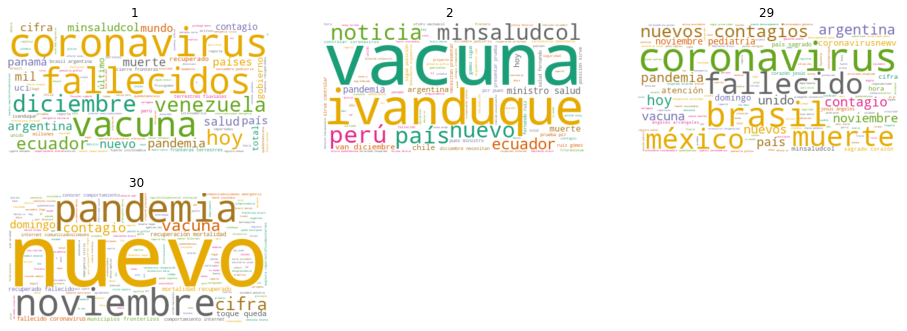

In [269]:
wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

for index, day in enumerate(data_dtm.columns):
    wc.generate(data_clean.texto[day])
    plt.subplot(4, 3, index+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(day)
plt.show()

In [276]:
c_vec = CountVectorizer(stop_words = stop_words, ngram_range=(2,3))
ngrams = c_vec.fit_transform(df_tweets['texto'])
count_values = ngrams.toarray().sum(axis = 0)
vocab = c_vec.vocabulary_

df_tweets_ngram = pd.DataFrame(sorted([(count_values[i],k) for k,i in vocab.items()], reverse=True)
            ).rename(columns={0: 'frequency', 1:'bigram/trigram'})
df_tweets_ngram

frequency                      bigram/trigram
0             29    recuperado fallecido coronavirus
1             29                recuperado fallecido
2             29  recuperación mortalidad recuperado
3             29             recuperación mortalidad
4             29     mortalidad recuperado fallecido
...          ...                                 ...
11077          1                 aborto antiviral si
11078          1                    aborto antiviral
11079          1    abastecimiento nutrición hogares
11080          1            abastecimiento nutrición
11081          1                    abajo bdzaipzewj

[11082 rows x 2 columns]